# Case Study 3 - Results

In [ ]:
#import general packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco
from pathlib import Path
import pickle
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
import n_fct_t_rl_thm_ll as bond_fct
import prem_ibrd as prib
import functions as fct

file_path = "/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Thesis"
save_path = "/Users/kbergmueller/Library/CloudStorage/OneDrive-ETHZurich/Jobs/RA_ETH_25"

In [2]:
# define functions to derive efficient frontier

# Function to calculate portfolio risk (standard deviation)
def portfolio_risk(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Function to calculate portfolio return
def portfolio_return(weights, mean_returns):
        return np.sum(weights * mean_returns)

# Function for optimization: minimize risk for a given return
def minimize_risk(target_return, mean_returns, cov_matrix):
    # Number of assets in the portfolio
    num_assets = len(mean_returns)
    # Constraints: weights sum to 1, and portfolio return equals target return
    constraints = ({
        'type': 'eq', 'fun': lambda w: np.sum(w) - 1  # Weights sum to 1
    }, {
        'type': 'eq', 'fun': lambda w: portfolio_return(w, mean_returns) - target_return  # Target return constraint
    })
    # Initial guess: equal weights
    initial_guess = np.ones(num_assets) / num_assets
    # Bounds for weights: between 0 and 1
    bounds = tuple((0, 1) for asset in range(num_assets))
    # Minimize risk (objective function)
    result = sco.minimize(portfolio_risk, initial_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x, result.fun  # Return the optimized weights and the minimized risk

## Define Countries and Variables for Cat Bond Development

In [ ]:
# define countries eligible for finacial schme
countries = [480, 212, 882, 332, 670, 388, 662, 214, 548, 242, 776, 174, 584] 
countries_iso_str = ['480', '212', '882', '332', '670', '388', '662', '214', '548', '242', '776', '174', '584']

# resultion and coordinate system requirements per country
countries_150 = [332, 388, 214, 44, 548, 192, 84, 90] 
fiji = [242]
countries_30 = [480, 212, 670, 28, 52, 662, 659, 308, 882, 780, 570, 776, 174, 184, 584, 585]

# iso 3 alpha codes
countries_str = ['MUS', 'DMA', 'WSM', 'HTI', 'VCT', 'JAM', 'LCA', 'DOM', 'VUT', 'FJI', 'TON', 'COM', 'MHL']

# assign risk pools for scenario 2
scenario_2 = [[480, 882, 332, 670, 388, 662, 548, 242, 776, 584], [212, 214, 174]]


# set risk free rate, either single value or array
rf_rates = 0.00
# set benchmark sharpe ratio
target_sharpe = 0.5
# inititate IBRD premium calculation function
params_ibrd = prib.init_prem_ibrd(file_path=Path(file_path),want_plot=False)
a, k, b = params_ibrd
# define bond setting
lower_share = 0.05
prot_rp = 250


## Designe Multi-Country Bond
### Set Variables for Multi-Country Bond

In [ ]:
# import data for single country bonds 
sng_ann_ret_df_ibrd = pd.read_csv(str(file_path + "simulation_results/sng_returns_ibrd.csv"))[countries_iso_str]
sng_ann_ret_df_regression = pd.read_csv(str(file_path + "simulation_results/sng_returns_regression.csv"))[countries_iso_str]
sng_ann_ret_df_required = pd.read_csv(str(file_path + "simulation_results/sng_returns_required.csv"))[countries_iso_str]
output_path = Path(file_path, "simulation_results/bond_metrics_sng_dic.pkl")
with open(output_path, "rb") as file:
    bond_metrics_sng_dic = pickle.load(file)

bond_metrics_sng_dic = {key: bond_metrics_sng_dic[key] for key in countries}

sng_ann_ret_required = sng_ann_ret_df_required.to_dict('series')
sng_ann_ret_regression = sng_ann_ret_df_regression.to_dict('series')
sng_ann_ret_ibrd = sng_ann_ret_df_ibrd.to_dict('series')

nominal_sng_dic_df = pd.read_csv(str(file_path + "simulation_results/nominal_dic_df.csv"))
# Specify the output path
output_path = Path(file_path, "simulation_results/pay_dam_df_dic.pkl")
with open(output_path, "rb") as file:
    pay_dam_df_sng_dic = pickle.load(file)
pay_dam_df_sng_dic = {key: pay_dam_df_sng_dic[key] for key in countries}

nominal_sng_dic = dict(zip(nominal_sng_dic_df["Key"], nominal_sng_dic_df["Value"]))
nominal_sng_dic = {key: nominal_sng_dic[key] for key in countries}

### Create Multi-Country bond

In [ ]:
# simulate sceanrio 2
# define tranches
tranches_array = np.array([50, 250, 1000])

ncf_s2 = {}
premiums_s2 = {}
premium_dic_s2 = {}
nominal_s2 = {}
es_metrics_s2 = {}
MES_cty_s2 = {}
tranches_s2 = {}

i = 0
for pool in scenario_2:
    i += 1
    if len(pool) > 1:
        nominal_dic_pool = {}
        pay_dam_df_dic_pool = {}
        for cty in pool:
            nominal_dic_pool[cty] = nominal_sng_dic[cty]
            pay_dam_df_dic_pool[cty] = pay_dam_df_sng_dic[cty]
        ncf_s2[str(i)], premiums_s2[str(i)], premium_dic_s2[str(i)], nominal_s2[str(i)], es_metrics_s2[str(i)], MES_cty_s2[str(i)], tranches_s2[str(i)] = bond_fct.mlt_cty_bond(countries=pool,pay_dam_df_dic=pay_dam_df_dic_pool,
                                                                                                                                                                                nominals_dic=nominal_dic_pool, tranches_array=tranches_array, 
                                                                                                                                                                                opt_cap=True, ibrd_path=Path(file_path),
                                                                                                                                                                                peak_multi=0)

c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 25.32%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 0.62%


In [6]:
# extract for each scenario the simulated returns per pricing approach
s2_tranches_ann_ret_regr = {}
s2_tranches_ann_ret_ibrd = {}
s2_tranches_ann_ret_requ = {}

for key in ncf_s2["1"]['regression']:
    if key != 'Total':
        for pool in ncf_s2:
            s2_tranches_ann_ret_regr[f"{pool}: {key}"] = ncf_s2[pool]['regression'][key] / tranches_s2[pool].loc[tranches_s2[pool]['RP'] == key, 'nominal'].iloc[0]
            s2_tranches_ann_ret_ibrd[f"{pool}: {key}"] = ncf_s2[pool]['ibrd'][key] / tranches_s2[pool].loc[tranches_s2[pool]['RP'] == key, 'nominal'].iloc[0]
            s2_tranches_ann_ret_requ[f"{pool}: {key}"] = ncf_s2[pool]['required'][key] / tranches_s2[pool].loc[tranches_s2[pool]['RP'] == key, 'nominal'].iloc[0]

i = 0
for pool in scenario_2:
    i += 1
    if len(pool) == 1:
        s2_tranches_ann_ret_regr[str(i)] = sng_ann_ret_regression[str(pool[0])]
        s2_tranches_ann_ret_ibrd[str(i)] = sng_ann_ret_ibrd[str(pool[0])]
        s2_tranches_ann_ret_requ[str(i)] = sng_ann_ret_required[str(pool[0])]

s2_ann_ret_regr = {}
s2_ann_ret_ibrd = {}
s2_ann_ret_requ = {}
for pool in ncf_s2:
    s2_ann_ret_regr[pool] = 0
    s2_ann_ret_ibrd[pool] = 0
    s2_ann_ret_requ[pool] = 0
    for rp in ncf_s2[pool]['regression']:
        if rp != 'Total':
            s2_ann_ret_regr[pool] += ncf_s2[pool]['regression'][rp]
            s2_ann_ret_ibrd[pool] += ncf_s2[pool]['ibrd'][rp]
            s2_ann_ret_requ[pool] += ncf_s2[pool]['required'][rp]

i = 0
for pool in scenario_2:
    i += 1
    if len(pool) == 1:
        s2_ann_ret_regr[str(i)] = sng_ann_ret_regression[str(pool[0])]
        s2_ann_ret_ibrd[str(i)] = sng_ann_ret_ibrd[str(pool[0])]
        s2_ann_ret_requ[str(i)] = sng_ann_ret_required[str(pool[0])]

In [8]:
bond_names = list(sng_ann_ret_required.keys())
returns_matrix = np.array([sng_ann_ret_required[bond] for bond in bond_names])  # Shape (num_bonds, num_years)
principal_weights = np.array([nominal_sng_dic[int(bond)] for bond in bond_names])  # Shape (num_bonds,)

# Normalize principal to get portfolio weights
weights = principal_weights / principal_weights.sum()

# Compute portfolio returns for each year
portfolio_returns = np.dot(weights, returns_matrix)  # Weighted sum per year

# Compute annual mean return and volatility
mean_return = np.mean(portfolio_returns)
volatility = np.std(portfolio_returns, ddof=1)  # Use ddof=1 for sample std

print(f"Annual Mean Return: {mean_return:.4f}")
print(f"Annual Volatility: {volatility:.4f}")

Annual Mean Return: 0.0618
Annual Volatility: 0.0780


In [9]:
print("IBRD-Returns: ",np.mean((s2_ann_ret_ibrd['1'] * nominal_s2['1'] + s2_ann_ret_ibrd['2'] * nominal_s2['2']) / (nominal_s2['1'] + nominal_s2['2'])))
print("IBRD-STD: ",np.std((s2_ann_ret_ibrd['1'] * nominal_s2['1'] + s2_ann_ret_ibrd['2'] * nominal_s2['2']) / (nominal_s2['1'] + nominal_s2['2'])))
print("Chatoro-Returns: ",np.mean((s2_ann_ret_regr['1'] * nominal_s2['1'] + s2_ann_ret_regr['2'] * nominal_s2['2']) / (nominal_s2['1'] + nominal_s2['2'])))
print("Chatoro-STD: ",np.std((s2_ann_ret_regr['1'] * nominal_s2['1'] + s2_ann_ret_regr['2'] * nominal_s2['2']) / (nominal_s2['1'] + nominal_s2['2'])))
print("Benchmark-Returns: ",np.mean((s2_ann_ret_requ['1'] * nominal_s2['1'] + s2_ann_ret_requ['2'] * nominal_s2['2']) / (nominal_s2['1'] + nominal_s2['2'])))
print("Benchmark-STD: ",np.std((s2_ann_ret_requ['1'] * nominal_s2['1'] + s2_ann_ret_requ['2'] * nominal_s2['2']) / (nominal_s2['1'] + nominal_s2['2'])))

IBRD-Returns:  0.02436917486040866
IBRD-STD:  0.0865627955602886
Chatoro-Returns:  0.06836878901895918
Chatoro-STD:  0.08794417489823803
Benchmark-Returns:  0.05852118515593609
Benchmark-STD:  0.08767951752280767


Sng Premiums ibrd: 2510337608.9557095
S2 Premiums ibrd: 2099218461.3394318; 0.836229538947432
Sng Premiums required: 3851878209.853583
S2 Premiums required: 3424545575.572723; 0.8890586329578931
Sng Premiums regression: 4106411948.4440765
S2 Premiums regression: 3806698669.840273; 0.9270133434329779
Sng Nominal: 43630876300.25018
S2 Nominal: 38806708675.85378; 0.8894322545529818


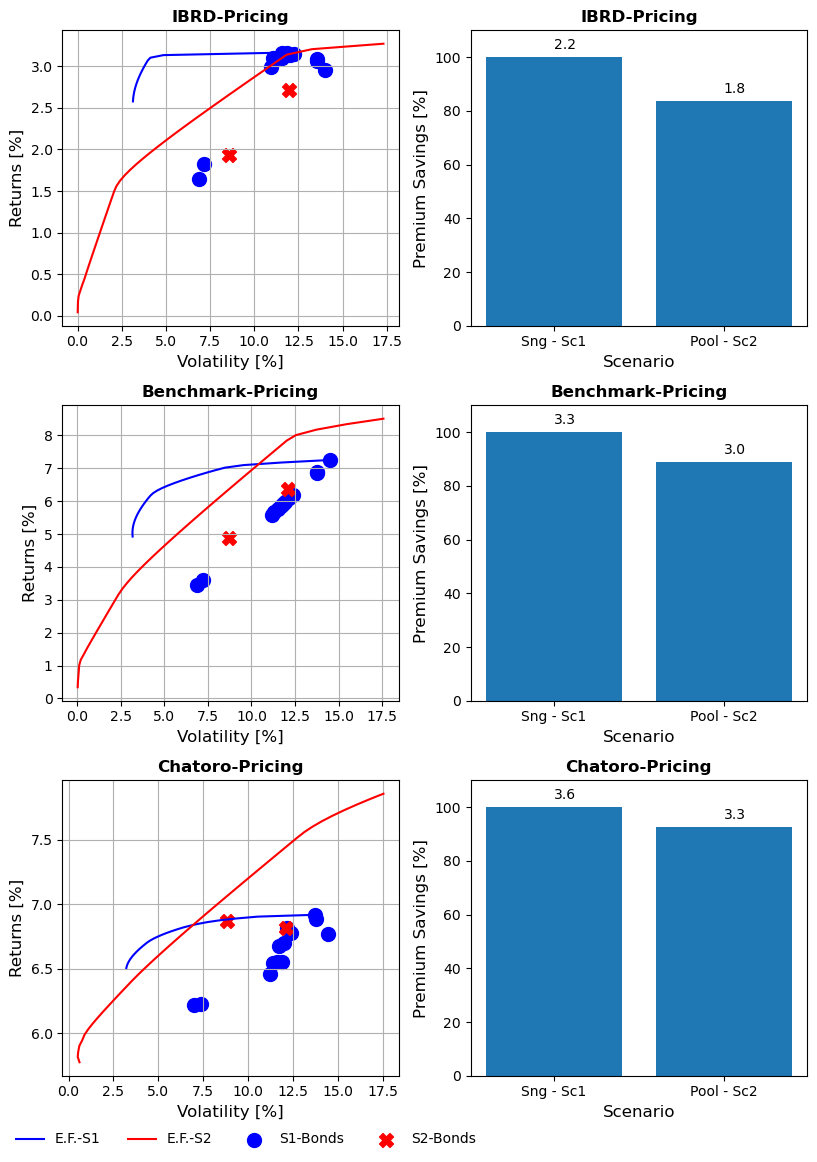

In [10]:
# use returns, premium payments and payouts to derive efficient frontiers, premium savings and insurance multiples for each scenario and pricing approach

premiums_abs_keys = ['Sng', 'S2']
premiums_abs = {key: {} for key in premiums_abs_keys}
premium_methods = ['ibrd', 'required', 'regression']
premium_methods_title = ['IBRD-Pricing', 'Benchmark-Pricing', 'Chatoro-Pricing']
num_plots = len(premium_methods)
fig, axes = plt.subplots(num_plots, 2, figsize=(8.27, 4 * num_plots)) 

for j, prem_mode in enumerate(premium_methods): 
    premiums_pool_s2 = {}
    for pool, prem_modes in premiums_s2.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s2:  
                    premiums_pool_s2[key] += np.sum(values * nominal_s2[pool])
                else:  
                    premiums_pool_s2[key] = np.sum(values * nominal_s2[pool])
            
    if prem_mode == 'ibrd':
        sng_ann_ret = sng_ann_ret_ibrd
        sng_ann_ret_df = sng_ann_ret_df_ibrd
        s2_tranches_ann_ret_df = s2_tranches_ann_ret_ibrd
        s2_ann_ret = s2_ann_ret_ibrd
        sng_cty_premium = []
        sng_cty_pay = []
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][0])
            sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][0])
        for pool in scenario_2:
            if len(pool) == 1:
                premiums_pool_s2['Total_alt'] += bond_metrics_sng_dic[pool[0]]['Total Premiums'][0]
                premiums_pool_s2[pool[0]] = bond_metrics_sng_dic[pool[0]]['Total Premiums'][0]
        threshold_ef = 0.0255

    elif prem_mode == 'regression':
        sng_ann_ret = sng_ann_ret_regression
        sng_ann_ret_df = sng_ann_ret_df_regression
        s2_tranches_ann_ret_df = s2_tranches_ann_ret_regr
        s2_ann_ret = s2_ann_ret_regr
        sng_cty_premium = []
        sng_cty_pay = []
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][1])
            sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][1])
        for pool in scenario_2:
            if len(pool) == 1:
                premiums_pool_s2['Total_alt'] += bond_metrics_sng_dic[pool[0]]['Total Premiums'][1]
                premiums_pool_s2[pool[0]] = bond_metrics_sng_dic[pool[0]]['Total Premiums'][1]
        threshold_ef = 0.065

    elif prem_mode == 'required':
        sng_ann_ret = sng_ann_ret_required
        sng_ann_ret_df = sng_ann_ret_df_required
        s2_tranches_ann_ret_df = s2_tranches_ann_ret_requ
        s2_ann_ret = s2_ann_ret_requ
        sng_cty_premium = []
        sng_cty_pay = []
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][2])
            sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][2])
        for pool in scenario_2:
            if len(pool) == 1:
                premiums_pool_s2['Total_alt'] += bond_metrics_sng_dic[pool[0]]['Total Premiums'][2]
                premiums_pool_s2[pool[0]] = bond_metrics_sng_dic[pool[0]]['Total Premiums'][2]
        threshold_ef = 0.049
    else:
        print('Wrong input premium mode')
        break

    df_returns = pd.DataFrame({f"{country} Returns": returns for country, returns in sng_ann_ret.items()})
    df_returns_s2 = pd.DataFrame({f"{country} Returns": returns for country, returns in s2_tranches_ann_ret_df.items()}).dropna(axis=1)

    # derive returns
    r = np.mean(df_returns,axis=0)
    r_s2= np.mean(df_returns_s2,axis=0)

    # Create a covariance matrix
    covar = df_returns.cov()
    covar_s2 = df_returns_s2.cov()

    # Generate a series of target returns and corresponding risks
    target_returns = np.linspace(np.min(r), np.max(r), 50) 
    risks = []
    for target_return in target_returns:
        weights, risk = minimize_risk(target_return, r, covar)
        risks.append(risk)

    risks_s2 = []
    target_returns_s2 = np.linspace(np.min(r_s2), np.max(r_s2), 50)
    for target_return in target_returns_s2:
        weights, risk = minimize_risk(target_return, r_s2, covar_s2)
        risks_s2.append(risk)

    filtered_target_returns = [value for value in target_returns if value > threshold_ef]
    filtered_risks = [risks[i] for i in range(len(target_returns)) if target_returns[i] > threshold_ef]
    axes[j, 0].plot(np.array(filtered_risks)*100, np.array(filtered_target_returns)*100, label="E.F.-S1", color='blue')
    axes[j, 0].plot(np.array(risks_s2)*100, np.array(target_returns_s2)*100, label="E.F.-S2", color='red')

    for i, cty in enumerate(countries):
        if i == 0:
            axes[j, 0].scatter(np.std(sng_ann_ret[str(cty)])*100, np.mean(sng_ann_ret[str(cty)])*100, color='blue', label='S1-Bonds', s=100)
        else:
            axes[j, 0].scatter(np.std(sng_ann_ret[str(cty)])*100, np.mean(sng_ann_ret[str(cty)])*100, color='blue', s=100)
    for pool in s2_ann_ret:
        if pool == '1':
            axes[j, 0].scatter(np.std(s2_ann_ret[pool])*100, np.mean(s2_ann_ret[pool])*100, color='red', label=f'S2-Bonds', marker='X', s=100)
        else:
            axes[j, 0].scatter(np.std(s2_ann_ret[pool])*100, np.mean(s2_ann_ret[pool])*100, color='red', marker='X', s=100)
    axes[j, 0].set_xlabel("Volatility [%]", fontsize=12)
    axes[j, 0].set_ylabel("Returns [%]", fontsize=12)
    axes[j, 0].grid(True)
    axes[j, 0].set_title(f"{premium_methods_title[j]}", fontsize=12, fontweight='bold')


    x_labels = ["Sng - Sc1", "Pool - Sc2"]
    s_pool = []
    n = []
    s = sng_cty_premium
    prem_diff = [np.sum(s)/np.sum(s), 
                 np.sum(premiums_pool_s2['Total_alt'])/np.sum(s)]

    tot_pay_s2 = 0
    for pool in es_metrics_s2:
        tot_pay_s2 += es_metrics_s2[pool]['Payout']
    for pool in scenario_2:
        if len(pool) == 1:
            tot_pay_s2 += bond_metrics_sng_dic[pool[0]]['Summed Payments'][0]

    im = [np.sum(s)/np.sum(sng_cty_pay), 
          np.sum(premiums_pool_s2['Total_alt'])/tot_pay_s2]

    for q in range(len(im)):
        axes[j, 1].text(x_labels[q], prem_diff[q]*100+3, round(im[q],1))
    axes[j, 1].bar(x_labels, np.array(prem_diff)*100, label='Premium Savings')
    axes[j, 1].set_xlabel("Scenario", fontsize=12)
    axes[j, 1].set_ylabel("Premium Savings [%]", fontsize=12)
    axes[j, 1].set_ylim(0, 110)
    axes[j, 1].tick_params(axis='y')
    axes[j, 1].set_title(f"{premium_methods_title[j]}", fontsize=12, fontweight='bold')
    
    premiums_abs['Sng'][prem_mode] = np.sum(sng_cty_premium)/len(sng_ann_ret['212'])
    premiums_abs['S2'][prem_mode] = premiums_pool_s2['Total_alt']/len(sng_ann_ret['212'])

    print(f"Sng Premiums {prem_mode}: {premiums_abs['Sng'][prem_mode]}")
    print(f"S2 Premiums {prem_mode}: {premiums_abs['S2'][prem_mode]}; {premiums_abs['S2'][prem_mode] / premiums_abs['Sng'][prem_mode]}")

nominal_sng = 0
for key in nominal_sng_dic:
    nominal_sng += nominal_sng_dic[key]
print(f"Sng Nominal: {nominal_sng}")
nominal_pool_s2 = 0
for key in nominal_s2:
    nominal_pool_s2 += nominal_s2[key]
for pool in scenario_2:
    if len(pool) == 1:
        nominal_pool_s2 += nominal_sng_dic[pool[0]]
print(f"S2 Nominal: {nominal_pool_s2}; {nominal_pool_s2 / nominal_sng}")



handles0, labels0 = axes[j, 0].get_legend_handles_labels()
fig.legend(
    handles0,
    labels0,
    loc='lower left',
    bbox_to_anchor=(0.01, 0.03),
    ncol=4,
    frameon=False,
)

# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


In [11]:
# set data of historical returns of norwegian pension fund
# Example data
risk_nor = np.array([0.02, 9.54, 4.80, 6.74, 17.83])  # Avoid zero to prevent issues
returns_nor = np.array([0.02, 4.29, 3.99, 4.42, 8.05])
labels = ["", "Ren. Infrastructure", "Fixed Income", "Real Estate", "Equity"] # forst entry is the risk free rate approximated as average 3-month US treasury bills

# Define the power law function to fit the risk return trendline
def power_law_func(x, a, b):
    return a * x**b

# Fit the trendline to the data
params, _ = curve_fit(power_law_func, risk_nor, returns_nor, maxfev=10000)
a, b = params

# Generate smooth values for the trendline
smooth_risk = np.linspace(0, max(risk_nor), 100)
smooth_trendline = power_law_func(smooth_risk, a, b)

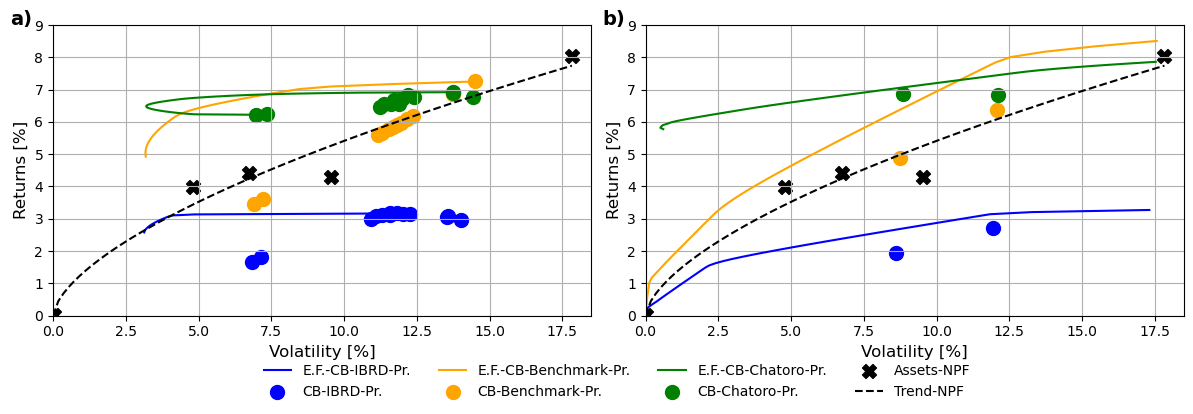

In [12]:
# compare risk return ratio of Norwegian Pension fund to Cat bonds efficient frontiers

premium_methods = ['ibrd', 'required', 'regression'] 
premium_methods_title = ['IBRD-Pr.', 'Benchmark-Pr.', 'Chatoro-Pr.'] 
cmap = ['blue', 'orange', 'green']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 2 columns for function and derivative

for j, prem_mode in enumerate(premium_methods): 
    premiums_pool_s2 = {}
    for pool, prem_modes in premiums_s2.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s2:  # If the key already exists, sum the values
                    premiums_pool_s2[key] += np.sum(values * nominal_s2[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s2[key] = np.sum(values * nominal_s2[pool])
            
    if prem_mode == 'ibrd':
        sng_ann_ret = sng_ann_ret_ibrd
        sng_ann_ret_df = sng_ann_ret_df_ibrd
        s2_tranches_ann_ret_df = s2_tranches_ann_ret_ibrd
        s2_ann_ret = s2_ann_ret_ibrd
        sng_cty_premium = []
        sng_cty_pay = []
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][0])
            sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][0])
        for pool in scenario_2:
            if len(pool) == 1:
                premiums_pool_s2['Total_alt'] += bond_metrics_sng_dic[pool[0]]['Total Premiums'][0]
                premiums_pool_s2[pool[0]] = bond_metrics_sng_dic[pool[0]]['Total Premiums'][0]
        threshold_ef = 0.0255

    elif prem_mode == 'regression':
        sng_ann_ret = sng_ann_ret_regression
        sng_ann_ret_df = sng_ann_ret_df_regression
        s2_tranches_ann_ret_df = s2_tranches_ann_ret_regr
        s2_ann_ret = s2_ann_ret_regr
        sng_cty_premium = []
        sng_cty_pay = []
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][1])
            sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][1])
        for pool in scenario_2:
            if len(pool) == 1:
                premiums_pool_s2['Total_alt'] += bond_metrics_sng_dic[pool[0]]['Total Premiums'][1]
                premiums_pool_s2[pool[0]] = bond_metrics_sng_dic[pool[0]]['Total Premiums'][1]
        threshold_ef = 0.047

    elif prem_mode == 'required':
        sng_ann_ret = sng_ann_ret_required
        sng_ann_ret_df = sng_ann_ret_df_required
        s2_tranches_ann_ret_df = s2_tranches_ann_ret_requ
        s2_ann_ret = s2_ann_ret_requ
        sng_cty_premium = []
        sng_cty_pay = []
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][2])
            sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][2])
        for pool in scenario_2:
            if len(pool) == 1:
                premiums_pool_s2['Total_alt'] += bond_metrics_sng_dic[pool[0]]['Total Premiums'][2]
                premiums_pool_s2[pool[0]] = bond_metrics_sng_dic[pool[0]]['Total Premiums'][2]
        threshold_ef = 0.049
    else:
        print('Wrong input premium mode')
        break

    df_returns = pd.DataFrame({f"{country} Returns": returns for country, returns in sng_ann_ret.items()})
    df_returns_s2 = pd.DataFrame({f"{country} Returns": returns for country, returns in s2_tranches_ann_ret_df.items()}).dropna(axis=1)

    r = np.mean(df_returns,axis=0)
    r_s2= np.mean(df_returns_s2,axis=0)

    covar = df_returns.cov()
    covar_s2 = df_returns_s2.cov()

    target_returns = np.linspace(np.min(r), np.max(r), 50) 
    risks = []
    for target_return in target_returns:
        weights, risk = minimize_risk(target_return, r, covar)
        risks.append(risk)

    risks_s2 = []
    target_returns_s2 = np.linspace(np.min(r_s2), np.max(r_s2), 50)
    for target_return in target_returns_s2:
        weights, risk = minimize_risk(target_return, r_s2, covar_s2)
        risks_s2.append(risk)

    filtered_target_returns = [value for value in target_returns if value > threshold_ef]
    filtered_risks = [risks[i] for i in range(len(target_returns)) if target_returns[i] > threshold_ef]
    ax1.plot(np.array(filtered_risks)*100, np.array(filtered_target_returns)*100, label=f"E.F.-CB-{premium_methods_title[j]}", color=cmap[j])
    for i, cty in enumerate(countries):
        if i == 0:
            ax1.scatter(np.std(sng_ann_ret[str(cty)])*100, np.mean(sng_ann_ret[str(cty)])*100, color=cmap[j], label=f'CB-{premium_methods_title[j]}', s=100)
        else:
            ax1.scatter(np.std(sng_ann_ret[str(cty)])*100, np.mean(sng_ann_ret[str(cty)])*100, color=cmap[j] , s=100)

    ax2.plot(np.array(risks_s2)*100, np.array(target_returns_s2)*100, label=f"E.F.-CB-{premium_methods_title[j]}", color=cmap[j])
    for pool in s2_ann_ret:
        if pool == '1':
            ax2.scatter(np.std(s2_ann_ret[pool])*100, np.mean(s2_ann_ret[pool])*100, color=cmap[j], label=f'CB-{premium_methods_title[j]}', s=100)
        else:
            ax2.scatter(np.std(s2_ann_ret[pool])*100, np.mean(s2_ann_ret[pool])*100, color=cmap[j], s=100)


ax1.scatter(risk_nor, returns_nor, marker='X', color='black', label='Assets-NPF', s=100)
ax1.plot(smooth_risk, smooth_trendline, color='black', linestyle='--', label="Trend-NPF")

ax1.set_xlabel("Volatility [%]", fontsize=12)
ax1.set_ylabel("Returns [%]", fontsize=12)
ax1.grid(True)
ax1.set_xlim(0.0, 18.5)
ax1.set_ylim(0.0, 9.0)

ax2.scatter(risk_nor, returns_nor, marker='X', color='black', label='Assets-NPF', s=100)
ax2.plot(smooth_risk, smooth_trendline, color='black', linestyle='--', label="E.F.-NPF")

ax2.set_xlabel("Volatility [%]", fontsize=12)
ax2.set_ylabel("Returns [%]", fontsize=12)
ax2.grid(True)
ax2.set_xlim(0.0, 18.5)
ax2.set_ylim(0.0, 9.0)

handles1, labels1 = ax1.get_legend_handles_labels()  
fig.legend(
    handles1,
    labels1,
    loc='lower right',
    bbox_to_anchor=(0.82, -0.04),
    ncol=4,
    frameon=False
)

panel_labels = ["a)", "b)"]
for i, ax in enumerate([ax1, ax2]):
    ax.annotate(panel_labels[i], 
                xy=(-0.08, 1),  
                xycoords="axes fraction",  
                fontsize=14, 
                fontweight="bold")

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


## Premium Donor Contributions

In [13]:
# define function to calculate what share premium donor countries pay for each country
def payout(value):
    if value <= 6.5:
        return 1
    elif value >= 16.5:
        return 0
    else:
        return (100 - (value - 6.5) * (100 / (16.5 - 6.5)))/100

# import carbon equivalent per capita footpring for each country    
country_em = {}
country_em[480] = 5.06
country_em[212] = 3.01
country_em[882] = 3.25
country_em[332] = 0.96
country_em[670] = 2.73
country_em[388] = 2.56
country_em[662] = 12.72
country_em[214] = 3.27
country_em[548] = 1.92
country_em[242] = -0.9
country_em[776] = 2.54
country_em[174] = 0.78
country_em[584] = 2.79

country_pss = {key: payout(country_em[key]) for key in country_em}
premium_methods = ['ibrd', 'regression', 'required'] 

country_ps_abs = {key: {} for key in premiums_abs_keys}
premium_support_abs = {key: {} for key in premiums_abs_keys}

#calcualte for sceanrio 1
for prem_mode in premium_methods:
    if prem_mode == 'ibrd':
        country_ps_abs[premiums_abs_keys[0]][prem_mode] = {key: country_pss[key] * (bond_metrics_sng_dic[key]['Total Premiums'][0]/len(sng_ann_ret['212'])) for key in country_pss}
    elif prem_mode == 'regression':
        country_ps_abs[premiums_abs_keys[0]][prem_mode] = {key: country_pss[key] * (bond_metrics_sng_dic[key]['Total Premiums'][1]/len(sng_ann_ret['212'])) for key in country_pss}
    elif prem_mode == 'required':
        country_ps_abs[premiums_abs_keys[0]][prem_mode] = {key: country_pss[key] * (bond_metrics_sng_dic[key]['Total Premiums'][2]/len(sng_ann_ret['212'])) for key in country_pss}
    premium_support_abs[premiums_abs_keys[0]][prem_mode] = 0
    for key in country_ps_abs[premiums_abs_keys[0]][prem_mode]:
        premium_support_abs[premiums_abs_keys[0]][prem_mode] += country_ps_abs[premiums_abs_keys[0]][prem_mode][key]
    print('Scenario 1: ',prem_mode,premium_support_abs[premiums_abs_keys[0]][prem_mode])


# calculate for scenario 2
for j, prem_mode in enumerate(premium_methods): 
    premiums_pool_s2 = {}
    for pool, prem_modes in premiums_s2.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s2:  # If the key already exists, sum the values
                    premiums_pool_s2[key] += np.sum(values * nominal_s2[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s2[key] = np.sum(values * nominal_s2[pool])
    country_ps_abs[premiums_abs_keys[1]][prem_mode] = {key: country_pss[key] * (premiums_pool_s2[key]/len(sng_ann_ret['212'])) for key in country_pss}
    premium_support_abs[premiums_abs_keys[1]][prem_mode] = 0
    for key in country_ps_abs[premiums_abs_keys[1]][prem_mode]:
        premium_support_abs[premiums_abs_keys[1]][prem_mode] += country_ps_abs[premiums_abs_keys[1]][prem_mode][key]
    print('Scenario 2: ',prem_mode,premium_support_abs[premiums_abs_keys[1]][prem_mode])

Scenario 1:  ibrd 2490835512.5813694
Scenario 1:  regression 4074888862.2875834
Scenario 1:  required 3820376369.748617
Scenario 2:  ibrd 2083932454.0058956
Scenario 2:  regression 3777189810.3976746
Scenario 2:  required 3400734915.616044


In [14]:
# create table for thesis including premium ranges for each scenario and premium donor share
rows = []

for country in next(iter(country_ps_abs.values()))['ibrd'].keys():
    sc1_premiums = []
    sc2_premiums = []
    
    for approach in country_ps_abs['Sng']:
        sc1_premiums.append(country_ps_abs['Sng'][approach].get(country, []))
        
    for approach in country_ps_abs['S2']:
        sc2_premiums.append(country_ps_abs['S2'][approach].get(country, []))
    
    # Calculate the min and max premiums for sc1 and sc2
    sc1_min = (round(min(sc1_premiums)  / 1000000, 1))
    sc1_max = (round(max(sc1_premiums)  / 1000000, 1))
    sc2_min = (round(min(sc2_premiums)  / 1000000, 1))
    sc2_max = (round(max(sc2_premiums)  / 1000000, 1))
    
    sc1_str = f"{sc1_min}-{sc1_max}"
    sc2_str = f"{sc2_min}-{sc2_max}"
    
    rows.append({
        'Country': country,
        'SC1 Premiums': sc1_str,
        'SC2 Premiums': sc2_str
    })

cty_share_ben_prem_df = pd.DataFrame(rows)
cty_share_ben_prem_df['Donation Share'] = list(map(int, (np.round(list(country_pss.values()),2)*100)))

latex_table_cty_ben = cty_share_ben_prem_df.to_latex(index=False, caption="", label="tab:cs3_ben_prem_don")
print(latex_table_cty_ben)


\begin{table}
\label{tab:cs3_ben_prem_don}
\begin{tabular}{rllr}
\toprule
Country & SC1 Premiums & SC2 Premiums & Donation Share \\
\midrule
480 & 361.9-610.9 & 298.2-575.6 & 100 \\
212 & 12.0-19.3 & 12.3-21.5 & 100 \\
882 & 15.9-26.8 & 9.6-18.5 & 100 \\
332 & 278.2-460.1 & 180.9-349.2 & 100 \\
670 & 17.6-28.7 & 12.3-23.8 & 100 \\
388 & 256.7-427.1 & 161.8-312.4 & 100 \\
662 & 11.9-19.2 & 9.3-17.9 & 38 \\
214 & 1458.8-2374.0 & 1353.7-2369.9 & 100 \\
548 & 12.9-21.8 & 7.8-15.1 & 100 \\
242 & 57.1-96.4 & 34.2-66.0 & 100 \\
776 & 3.9-6.9 & 2.1-4.0 & 100 \\
174 & 3.7-10.6 & 1.7-3.0 & 100 \\
584 & 0.4-1.2 & 0.1-0.3 & 100 \\
\bottomrule
\end{tabular}
\end{table}



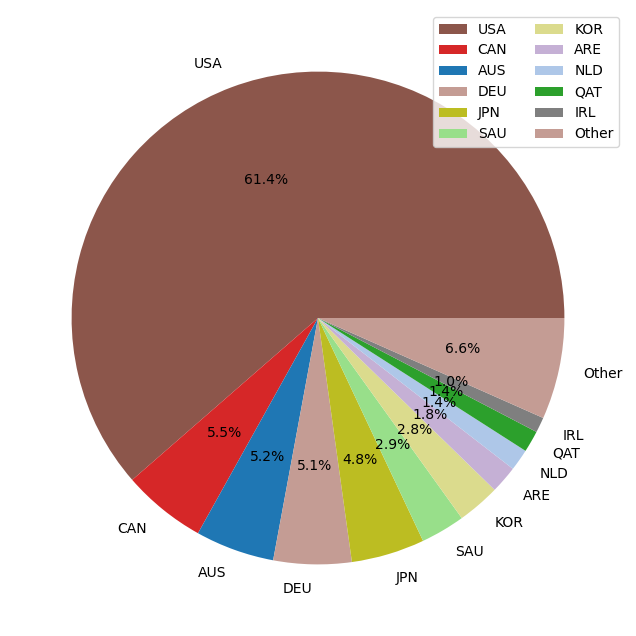

In [15]:
# derive share each premium donor has to pay and calculate absolute and realtive (to GDP) obligations per country
fs_share = fct.plot_prem_share(1, file_path=Path("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis"), eu=False)
for sce in premium_support_abs:
    for prem_mode in premium_support_abs[sce]:
        fs_share[f"{sce}_{prem_mode}_abs"] = fs_share['Share'] * premium_support_abs[sce][prem_mode]
        fs_share[f"{sce}_{prem_mode}_rel"] = fs_share['Share'] * premium_support_abs[sce][prem_mode] / (fs_share['GDP'] * 1000000) * 100

In [16]:
# create tables for premium donors and their finacial obligations
abs_columns = [col for col in fs_share.columns if col.endswith('_abs')]
rel_columns = [col for col in fs_share.columns if col.endswith('_rel')]

prem_don_obl = fs_share[["Country", "GDP", "CEFC"]].copy()
prem_don_obl['CEFC'] = prem_don_obl['CEFC'].round(1)
prem_don_obl['Premiums Absolute'] = (
    (fs_share[abs_columns] / 1000000)
    .agg(['min', 'max'], axis=1)
    .round(1)  # Round absolute values to 0 decimals
    .apply(lambda x: f"{x['min']} - {x['max']}", axis=1)
)
prem_don_obl['Premiums Relative'] = (
    fs_share[rel_columns]
    .agg(['min', 'max'], axis=1)
    .round(6)  # Round relative values to 4 decimals
    .apply(lambda x: f"{x['min']:.4f} - {x['max']:.4f}", axis=1)
)

# Step 3: Convert to LaTeX table
latex_table_prem_don = prem_don_obl.to_latex(index=False, caption="Premium Ranges for Each Country", label="tab:premium_ranges")

# Output the LaTeX code
print(latex_table_prem_don)

\begin{table}
\caption{Premium Ranges for Each Country}
\label{tab:premium_ranges}
\begin{tabular}{lrrll}
\toprule
Country & GDP & CEFC & Premiums Absolute & Premiums Relative \\
\midrule
AUS & 1723827 & 22.400000 & 107.9 - 211.1 & 0.0063 - 0.0122 \\
AUT & 516034 & 7.500000 & 10.8 - 21.2 & 0.0021 - 0.0041 \\
BHS & 14339 & 6.700000 & 0.3 - 0.5 & 0.0019 - 0.0036 \\
BHR & 43205 & 37.800000 & 4.6 - 8.9 & 0.0106 - 0.0207 \\
BEL & 632217 & 8.900000 & 15.8 - 30.8 & 0.0025 - 0.0049 \\
BRN & 15128 & 27.000000 & 1.1 - 2.2 & 0.0075 - 0.0147 \\
CAN & 2140086 & 19.200000 & 114.5 - 224.0 & 0.0054 - 0.0105 \\
CZE & 330858 & 10.300000 & 9.5 - 18.6 & 0.0029 - 0.0056 \\
DNK & 404199 & 7.600000 & 8.5 - 16.7 & 0.0021 - 0.0041 \\
EST & 40745 & 12.000000 & 1.4 - 2.7 & 0.0034 - 0.0066 \\
FIN & 300187 & 11.200000 & 9.4 - 18.3 & 0.0031 - 0.0061 \\
DEU & 4456081 & 8.600000 & 106.6 - 208.4 & 0.0024 - 0.0047 \\
GRC & 238206 & 6.800000 & 4.5 - 8.8 & 0.0019 - 0.0037 \\
ISL & 31020 & 9.100000 & 0.8 - 1.5 & 0.0025 - 

In [17]:
# create table for multi-country bond metrics of sceanrio 2

es_metrics_list = [es_metrics_s2]
premium_dic_list = [premium_dic_s2]

p_name = []
pool_numb = []
var_95_ls = []
var_99_ls = []
es_95_ls = []
es_99_ls = []
exp_lss_ls = []
att_prob_ls = []
for i, metrics in enumerate(es_metrics_list):
    for pool in metrics:
        p_name.append(i+2)
        pool_numb.append(pool)
        var_95_ls.append(metrics[pool]['VaR_95_ann'])
        var_99_ls.append(metrics[pool]['VaR_99_ann'])
        es_95_ls.append(metrics[pool]['ES_95_ann'])
        es_99_ls.append(metrics[pool]['ES_99_ann'])
    

for i, metrics in enumerate(premium_dic_list):
    for pool in metrics:
        exp_lss_ls.append(metrics[pool]['exp_loss'])
        att_prob_ls.append(metrics[pool]['att_prob'])

exp_lss_ls = np.array(exp_lss_ls) * 100
att_prob_ls = np.array(att_prob_ls) * 100
var_95_ls = np.array(var_95_ls) * 100
var_99_ls = np.array(var_99_ls) * 100
es_95_ls = np.array(es_95_ls) * 100
es_99_ls = np.array(es_99_ls) * 100

datamlt_b = {
    'Scenario': p_name,
    'Pool': pool_numb,
    'Expected Loss': np.round(exp_lss_ls, 1),
    'Attachment Probability': np.round(att_prob_ls,1),
    'VaR 95': np.round(var_95_ls,1),
    'VaR 99': np.round(var_99_ls,1),
    'ES 95': np.round(es_95_ls,1),
    'ES 99': np.round(es_99_ls,1)
}
df_mlt_b = pd.DataFrame(datamlt_b)


latex_table_mlt_b = df_mlt_b.to_latex(index=False, float_format="%.1f", caption="Example Table", label="tab:example_table")
print(latex_table_mlt_b)

\begin{table}
\caption{Example Table}
\label{tab:example_table}
\begin{tabular}{rlrrrrrr}
\toprule
Scenario & Pool & Expected Loss & Attachment Probability & VaR 95 & VaR 99 & ES 95 & ES 99 \\
\midrule
2 & 1 & 3.4 & 32.9 & 23.6 & 38.8 & 33.5 & 45.0 \\
2 & 2 & 2.7 & 12.7 & 23.9 & 66.1 & 49.4 & 80.4 \\
\bottomrule
\end{tabular}
\end{table}

